# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto
## Part II

In [2]:
import re
import pandas as pd
from bs4 import BeautifulSoup

def parse_postal_code(column):
    return column.find('b').get_text() 

def clean_column(column):
    elements = column.find('span')
    brs = elements.find_all('br')
    for br in brs:
        br.replace_with(' ')
    return elements

def find_neighborhoods(text):
    return ', '.join([s.strip() for s in text.replace('(', '').replace(')', '').split('/')])
    
def find_borough_and_neighborhoods(column):
    hoods_reg = re.compile('(?P<borough>.*)(?P<neighborhoods>\(.*\)?)')
    elements = clean_column(column)
    column_content = elements.get_text().strip()
    matches = hoods_reg.search(column_content)
    
    if matches:
        borough = matches.group('borough').strip()
        neighborhoods = find_neighborhoods(matches.group('neighborhoods'))
    else:
        borough = column_content
        neighborhoods = borough
        
    return (borough, neighborhoods)

def parse_column(column):
    postal_code = parse_postal_code(column)
    borough, neighborhoods = find_borough_and_neighborhoods(column)
            
    return [postal_code, borough, neighborhoods]
    
def parse_page(html):
    soup = BeautifulSoup(html, 'html.parser')
    
    container = soup.find('div', id='mw-content-text')
    table = container.find('table').find('tbody')
    df = pd.DataFrame(columns=['PostalCode', 'Borough', 'Neighborhoods'])
    for row in table.find_all('tr'):
        for column in row.find_all('td'):
            not_assigned = column.find('i')
            if not_assigned: continue

            df.loc[len(df)] = parse_column(column)    
            
    return df

def process_page(url):
    df = None
    with open(url) as content:
        df = parse_page(content)
    return df

wiki_url = './toronto_postal_codes.htm'
!wget -q -O 'toronto_postal_codes.htm' https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

toronto_df = process_page(wiki_url)

In [3]:
print(toronto_df.head())

  PostalCode           Borough                     Neighborhoods
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park                      Queen's Park


Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. In order to do that, we will need to leverage the Google Maps Geocoding API.

So, follow the following instructions to create a Google Maps Geocoding API key, and then use it to add two more columns to our dataframe that will contain the latitude and longitude coordinates of each neighborhood.

1. Go to https://console.developers.google.com/apis/library?filter=category:maps.
2. Choose the Geocoding API tile.
3. On the next page, click the Enable button.
4. On the next page, select the Credentials tab, and then click Create credentials and select the API key option.
5. Click the copy icon next to the key that you just generated.

Now, using this API key, you can make calls to the Google Geocoding API to get the latitude and longitude coordinates of the postal codes in our dataframe. Here is a demonstration of how we can use the Google Geocoding API to get the latitude and the longitude of the postal code **M5G**:

```python
# save your API key
API_key = *****************

# construct URL to make API call
url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(API_key, 'M5G')

response = requests.get(url).json() # get response
geographical_data = response['results'][0]['geometry']['location'] # get geographical coordinates
latitude = geographical_data['lat']
longitude = geographical_data['lng']
```

Use the Google Geocoding API to get the latitude and the longitude coordinates for all the neighborhoods in our dataframe. Here is a sample of the resulting dataframe for your reference:

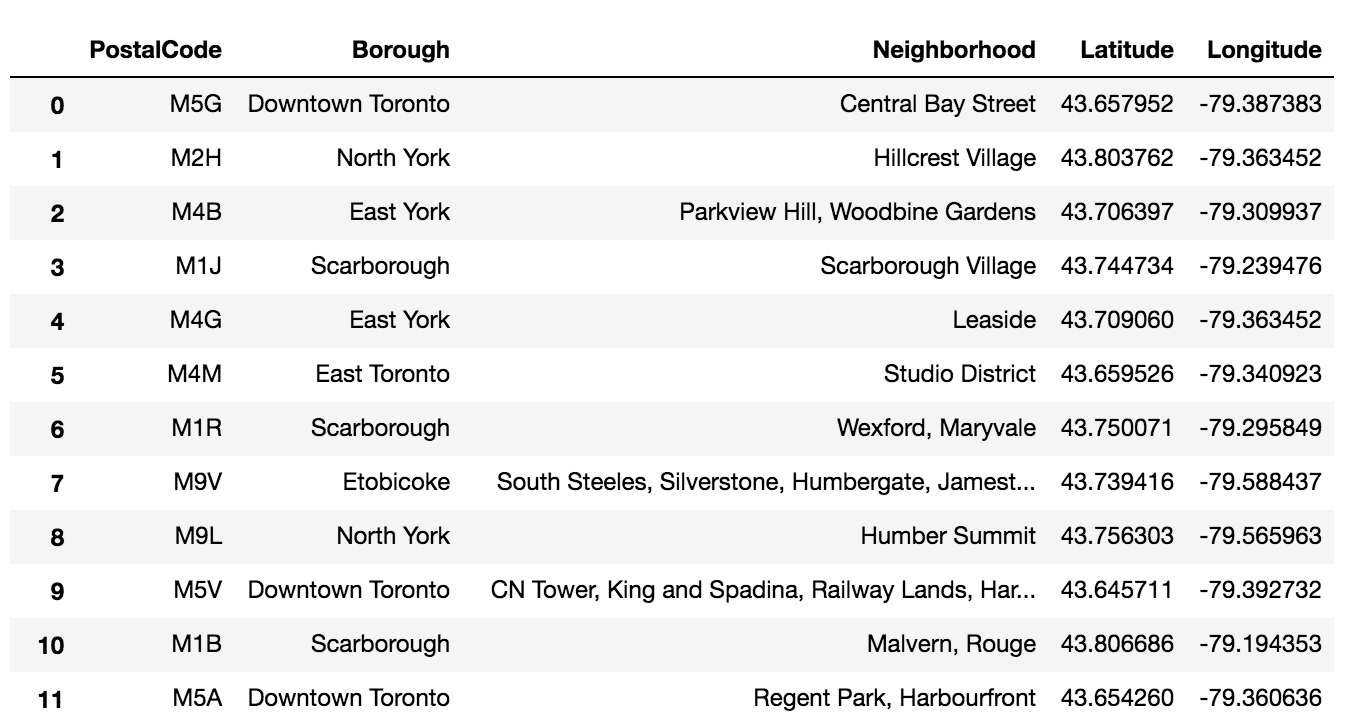

Once you are able to create the above dataframe, submit a link to the new Notebook on Watson Studio or the new Notebook on a Github repository pushed from your Watson Studio account. (**2 marks**)


In [5]:
# The code was removed by DSX for sharing.

In [10]:
import requests

In [41]:
url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(GOOGLE_API_KEY, 'M5G Toronto')

In [25]:
response = requests.get(url).json() # get response

In [58]:
response

{'results': [{'address_components': [{'long_name': 'M5G',
     'short_name': 'M5G',
     'types': ['postal_code', 'postal_code_prefix']},
    {'long_name': 'Old Toronto',
     'short_name': 'Old Toronto',
     'types': ['political', 'sublocality', 'sublocality_level_1']},
    {'long_name': 'Toronto',
     'short_name': 'Toronto',
     'types': ['locality', 'political']},
    {'long_name': 'Toronto Division',
     'short_name': 'Toronto Division',
     'types': ['administrative_area_level_2', 'political']},
    {'long_name': 'Ontario',
     'short_name': 'ON',
     'types': ['administrative_area_level_1', 'political']},
    {'long_name': 'Canada',
     'short_name': 'CA',
     'types': ['country', 'political']}],
   'formatted_address': 'Toronto, ON M5G, Canada',
   'geometry': {'bounds': {'northeast': {'lat': 43.662463, 'lng': -79.380601},
     'southwest': {'lat': 43.6511301, 'lng': -79.391719}},
    'location': {'lat': 43.6579524, 'lng': -79.3873826},
    'location_type': 'APPROXIMAT

In [27]:
geographical_data = response['results'][0]['geometry']['location']

In [28]:
print(geographical_data)

{'lat': 43.6579524, 'lng': -79.3873826}


In [29]:
latitude = geographical_data['lat']
longitude = geographical_data['lng']

In [50]:
toronto_df['Latitude'] = ""
toronto_df['Longitude'] = ""
toronto_df['Latitude'].astype(str)
toronto_df['Longitude'].astype(str)
toronto_df.head()

,PostalCode,Borough,Neighborhoods,Latitude,Longitude
0,M3A,North York,Parkwoods,,
1,M4A,North York,Victoria Village,,
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",,
3,M6A,North York,"Lawrence Manor, Lawrence Heights",,
4,M7A,Queen's Park,Queen's Park,,


In [42]:
def get_geopoint_from_google(address):
    url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(GOOGLE_API_KEY, address)
    response = requests.get(url).json() # get response
    geographical_data = response['results'][0]['geometry']['location']
    latitude = geographical_data['lat']
    longitude = geographical_data['lng']
    
    return (latitude, longitude)
    

In [55]:
for idx, row in toronto_df.iterrows():
    latitude, longitude = get_geopoint_from_google(row['PostalCode'] + " " + row['Borough'])
    toronto_df.loc[idx]['Latitude'] = "{0:.6f}".format(latitude)
    toronto_df.loc[idx]['Longitude'] = "{0:.6f}".format(longitude)

In [57]:
toronto_df.head()

,PostalCode,Borough,Neighborhoods,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662843,-79.389638
